In [ ]:
!pip install ipython-autotime
!pip install lightgbm

In [1]:
%matplotlib inline
%load_ext autotime

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from utils import MultipleTimeSeriesCV, format_time

sns.set_style('whitegrid')
#np.random.seed(42) # for consistent cv
idx = pd.IndexSlice


time: 1.44 s (started: 2021-04-30 14:34:36 +00:00)


In [8]:
# ignore following
# /opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
#  _log_warning('Overriding the parameters from Reference Dataset.')
import warnings
warnings.filterwarnings('ignore')

time: 512 µs (started: 2021-04-30 14:46:22 +00:00)


In [2]:
### set path
import os
from pathlib import Path
path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
path_result = path_home / 'result'

time: 755 µs (started: 2021-04-30 14:34:39 +00:00)


In [ ]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip .
!unzip stooq_jp_data.zip

!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_result.zip .
!unzip stooq_jp_result.zip

In [3]:
YEAR = 252
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
val_length = 2 * YEAR

time: 595 µs (started: 2021-04-30 14:34:57 +00:00)


In [4]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

time: 739 µs (started: 2021-04-30 14:34:57 +00:00)


In [5]:
cpu_count = os.cpu_count()
print('# of cpus:', cpu_count)

base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   n_jobs=cpu_count,
                   verbose=-1)

# of cpus: 2
time: 1.25 ms (started: 2021-04-30 14:34:59 +00:00)


In [6]:
daily_ic_avg = pd.read_csv(path_result / 'daily_ic_avg.csv')
daily_ic_avg.head()

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
0,1,63,5,0.5,0.75,250,25,0.005485
1,1,63,5,0.5,0.75,250,50,0.004826
2,1,63,5,0.5,0.75,250,75,0.005358
3,1,63,5,0.5,0.75,250,100,0.004369
4,1,63,5,0.5,0.75,250,125,0.003739


time: 23.4 ms (started: 2021-04-30 14:35:00 +00:00)



Lookahead: 01
Position: 00


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


Position: 01


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


Position: 02


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


Position: 03


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


Position: 04


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


Position: 05


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


Position: 06


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


Position: 07


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


Position: 08


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


Position: 09


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


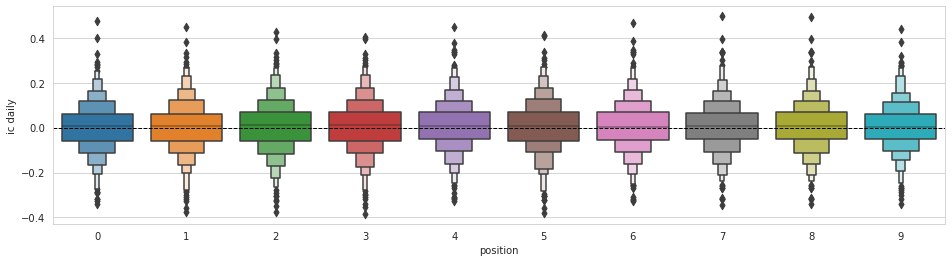

time: 11min 20s (started: 2021-04-30 14:35:02 +00:00)


In [7]:
num_models = 10
lookaheads = [1, 5, 10, 21]
lookaheads = lookaheads[:1]
train_start_year = '2012'

for lookahead in lookaheads:
    print(f'\nLookahead: {lookahead:02}')
    data = (pd.read_csv(path_data / 'stooq_jp_equities.csv', parse_dates=['date'])
              .set_index(['ticker','date'])
              .sort_index(level=['ticker','date'])
              .loc[idx[:, train_start_year:], :]
              )
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    data = data.loc[:, features + [label]].dropna()

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features],
                           label=data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(num_models):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'Position: {position:02}')

        n_splits = int(val_length / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            train_set = lgb_data.subset(used_indices=train_idx.tolist(),
                                        #params=params).construct()
                                        params=params)
    
            model = lgb.train(params=params,
                              train_set=train_set,
                              num_boost_round=num_boost_round,
                              categorical_feature=categoricals, 
                              verbose_eval=False)
        
            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))
            #train_test_perdios_msg(train_idx, test_idx, data)
            
        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        
    by_day = test_predictions.groupby(level='date')
    for position in range(num_models):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])
    test_predictions = test_predictions.sort_index(level=['ticker','date'])
    test_predictions.to_csv(path_result / f'test_{lookahead:02}.csv')

# plot ic
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxenplot(x='position', y='ic daily', 
                   data=pd.melt(ic_by_day).rename(columns={'variable':'position', 'value':'ic daily'}),
                   ax=ax )
ax.axhline(0, ls='--', lw=1, c='k');

In [10]:
# implemet for the case of y_test not known yet
test_predictions.tail()

y_test         0         1         2         3  \
ticker  date                                                           
9990.JP 2019-12-23  0.000000  0.001846  0.002281  0.002532  0.002624   
        2019-12-24 -0.009687 -0.007577 -0.007517 -0.007333 -0.007140   
        2019-12-25  0.001071 -0.006976 -0.007154 -0.007083 -0.006929   
        2019-12-26  0.000000 -0.007262 -0.007413 -0.007475 -0.007359   
        2019-12-27 -0.003257 -0.008236 -0.008439 -0.008359 -0.008038   

                           4         5         6         7         8         9  
ticker  date                                                                    
9990.JP 2019-12-23  0.002454  0.002568  0.002120  0.001899  0.001989  0.003142  
        2019-12-24 -0.007887 -0.007141 -0.008148 -0.008292 -0.008336 -0.010199  
        2019-12-25 -0.001734 -0.006902 -0.001968 -0.002126 -0.002060 -0.001598  
        2019-12-26 -0.007828 -0.007233 -0.008084 -0.008249 -0.008295 -0.010199  
        2019-12-27 -0.007035 -0.007970 -0.007296 -0.007470 -0.007516 -0.009217

time: 16.3 ms (started: 2021-04-30 15:45:42 +00:00)
